# Pasos previos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, r2_score, confusion_matrix, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Importación de los datos

In [2]:
df = pd.read_csv("archives/heart.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Muestra de datos

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trtbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalachh'}>],
       [<Axes: title={'center': 'exng'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slp'}>, <Axes: title={'center': 'caa'}>],
       [<Axes: title={'center': 'thall'}>,
        <Axes: title={'center': 'output'}>, <Axes: >, <Axes: >]],
      dtype=object)

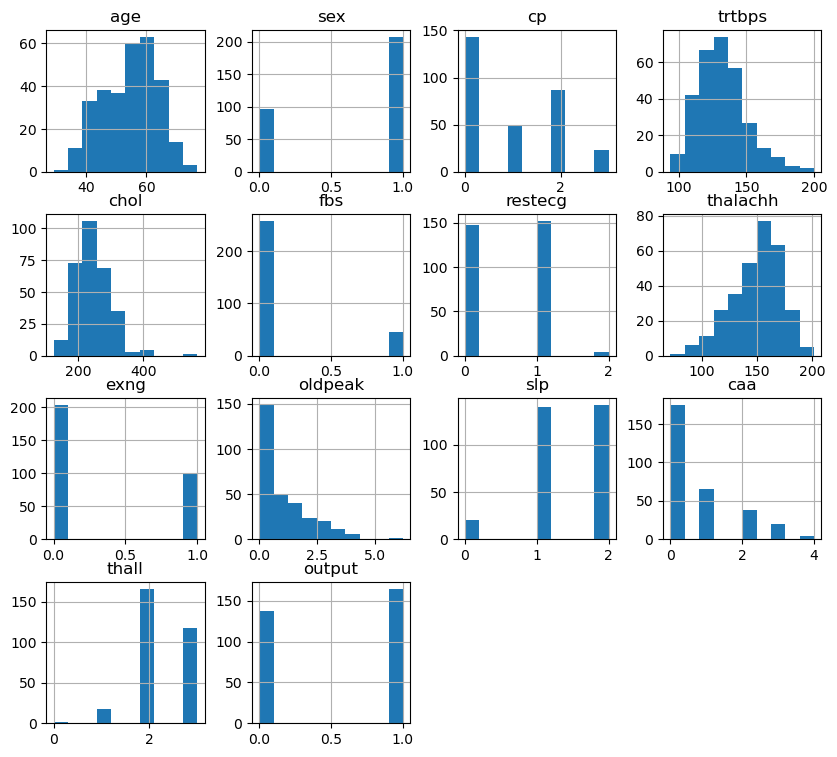

In [3]:
df.hist(figsize=(10,9))

<Axes: >

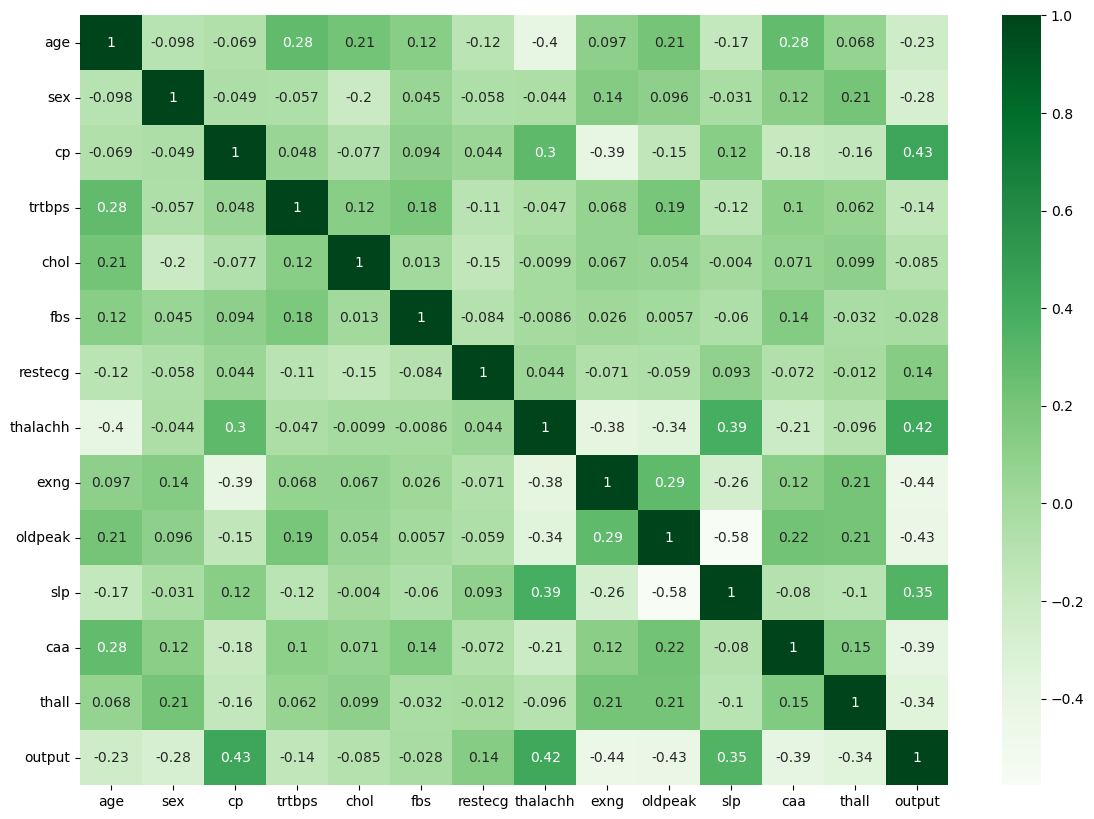

In [4]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap="Greens")

<Axes: >

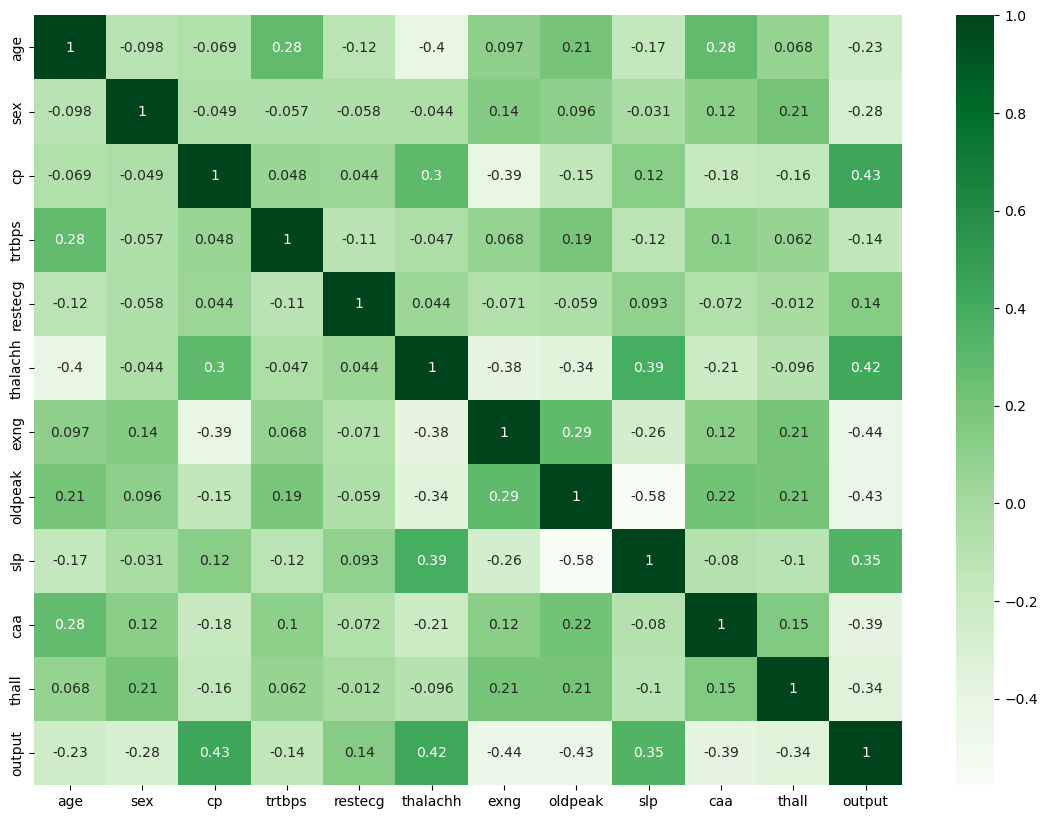

In [5]:
df.drop(["chol", "fbs"], axis=1, inplace=True)

plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap="Greens")

# Modelo

## Separación de datos

In [6]:
np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(df.drop("output", axis=1), df["output"], test_size=0.2, random_state=42) # Binario

x_train = StandardScaler().fit_transform(x_train.astype("float64"))
x_test = StandardScaler().fit_transform(x_test.astype("float64"))

## Métodos

In [7]:
lscores = []

def result(model, model_reg):
    predicciones = model_reg.predict(x_test)
    y_train_pred = cross_val_predict(model_reg, x_train, y_train, cv=3)
    lscores.append({
        "name" : model,
        "f1" : round(f1_score(y_train, y_train_pred), 4),
        "r2" : round(r2_score(y_test, predicciones), 4),
        "accuracy" : round(accuracy_score(y_train, y_train_pred), 4),
        "precission" : round(precision_score(y_train, y_train_pred), 4),
        "recall" : round(recall_score(y_train, y_train_pred), 4),
        "error_mse" : np.sqrt(mean_squared_error(y_test, predicciones)),
        "model_score" : cross_val_score(model_reg, x_train, y_train, cv=3, scoring="accuracy"),
        "error_mae" : mean_absolute_error(y_test, predicciones)
    })


def acc_rec_graph(models):
    plt.figure(figsize=(10,8))
    for name, model in models.items():
        try:
            y_scores = cross_val_predict(model, x_train, y_train, cv=3, method="decision_function")
            precisions, recalls, _ = precision_recall_curve(y_train, y_scores)
            plt.plot(recalls, precisions, label=name, linewidth=2)
        except AttributeError:
            print(f"{name} no tiene el metodo decision_function")

    plt.title("Precision/recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

def roc_graph(models):
    plt.figure(figsize=(10,8))
    for i, (name, model) in enumerate(models.items()):
        y_scores = cross_val_predict(model, x_train, y_train, cv=3, method="predict_proba")
        y_scores = y_scores[:,1]
        fpr, tpr, _ = roc_curve(y_train, y_scores)
        plt.plot(fpr, tpr, label=name)
        lscores[i]["roc_auc_score"] = round(roc_auc_score(y_train, y_scores), 4)
    
    plt.title("ROC curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

## Entrenamiento

In [8]:
models = {
    "SGDClassifier": SGDClassifier('log_loss'),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(), 
    'Naive Bayes': GaussianNB(),       
    'MLP Neural Network': MLPClassifier(max_iter=1000) 
}

In [9]:
for name, model in models.items():
    model.fit(x_train, y_train)
    result(name, model)

c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

## Precisión recall gráfica

Decision Tree no tiene el metodo decision_function
Random Forest no tiene el metodo decision_function
KNN no tiene el metodo decision_function
XGBoost no tiene el metodo decision_function


c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Naive Bayes no tiene el metodo decision_function
MLP Neural Network no tiene el metodo decision_function


<Figure size 1000x800 with 0 Axes>

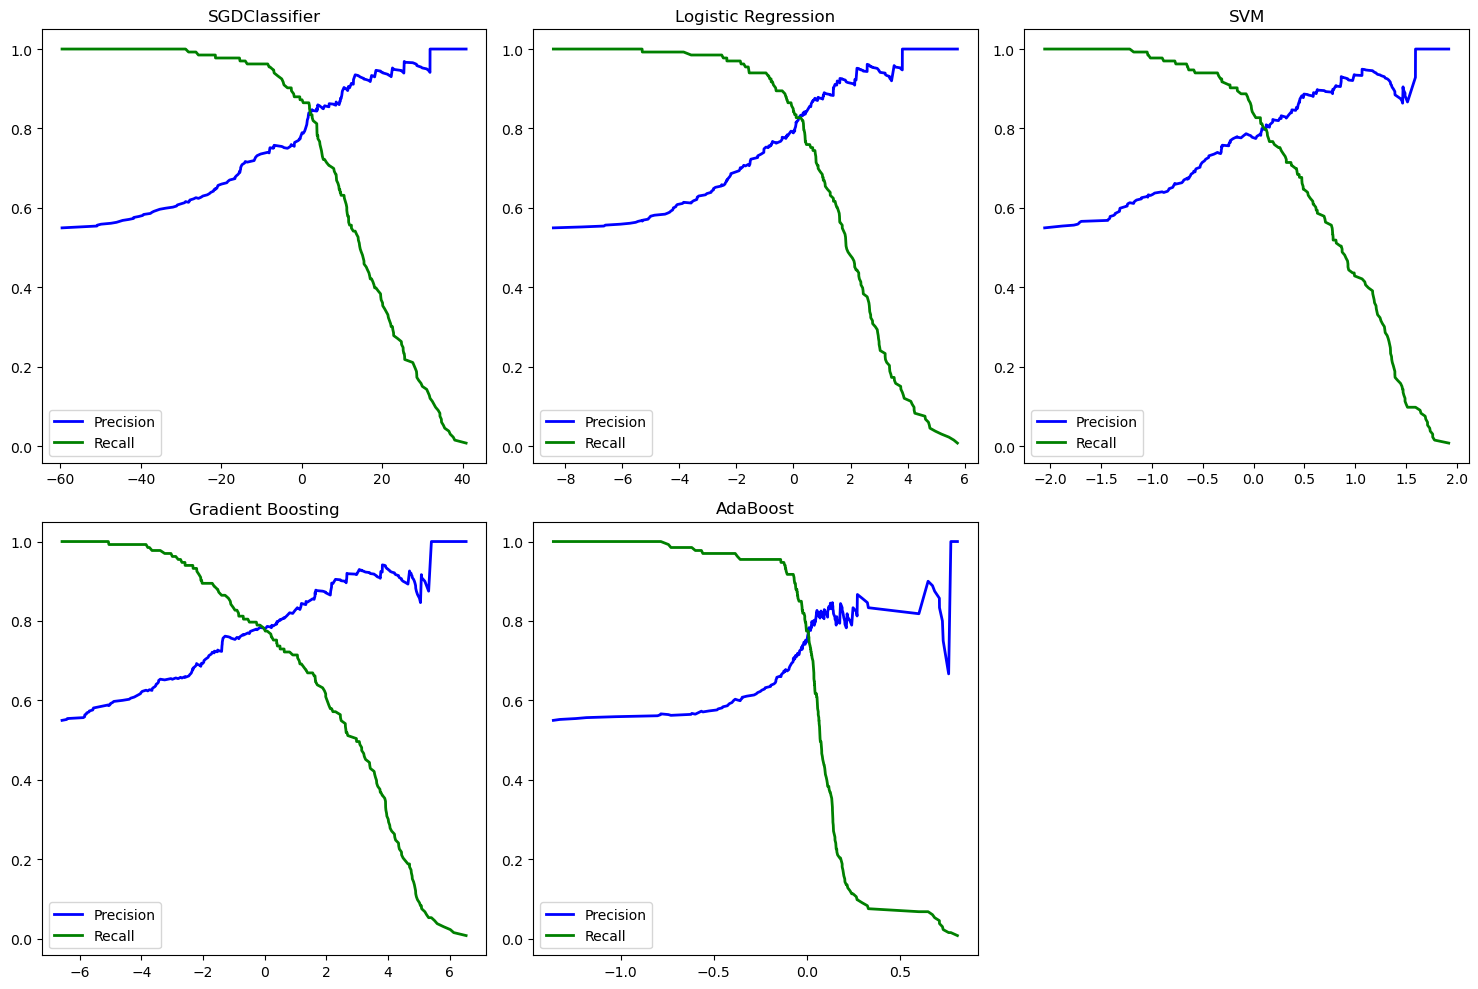

In [10]:
# TODO generalizacion del metodo

def prerec_curve(models):
    plt.figure(figsize=(10,8))
    fig, axes = plt.subplots(2, 3) # se que solo 5 van a funcionar por eso el TODO
    
    pos=0
    for name, model in models.items():
        try:
            y_scores = cross_val_predict(model, x_train, y_train, cv=3,
                             method="decision_function")
            precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

            axes.flatten()[pos].plot(thresholds, precisions[:-1], "b", label="Precision", linewidth=2)
            axes.flatten()[pos].plot(thresholds, recalls[:-1], "g", label="Recall", linewidth=2)
            axes.flatten()[pos].set_title(name)
            axes.flatten()[pos].legend()
            pos+=1
        except:
            print(f"{name} no tiene el metodo decision_function")
           
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.tight_layout()
    axes.flatten()[-1].set_axis_off()

prerec_curve(models)

## Precisión/Recall gráfica

Decision Tree no tiene el metodo decision_function
Random Forest no tiene el metodo decision_function
KNN no tiene el metodo decision_function
XGBoost no tiene el metodo decision_function


c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Naive Bayes no tiene el metodo decision_function
MLP Neural Network no tiene el metodo decision_function


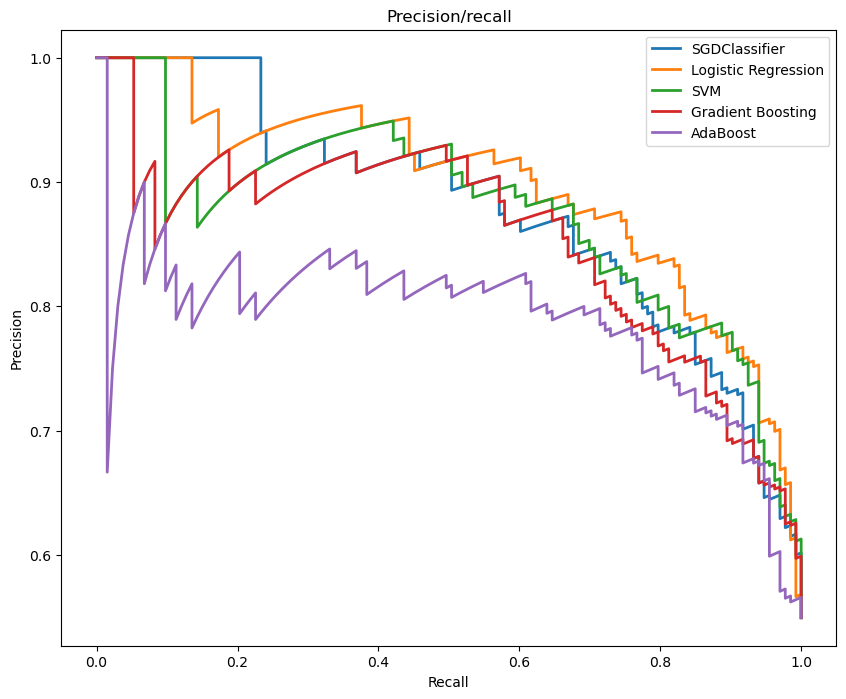

In [11]:
acc_rec_graph(models)

## Roc curve gráfica

c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


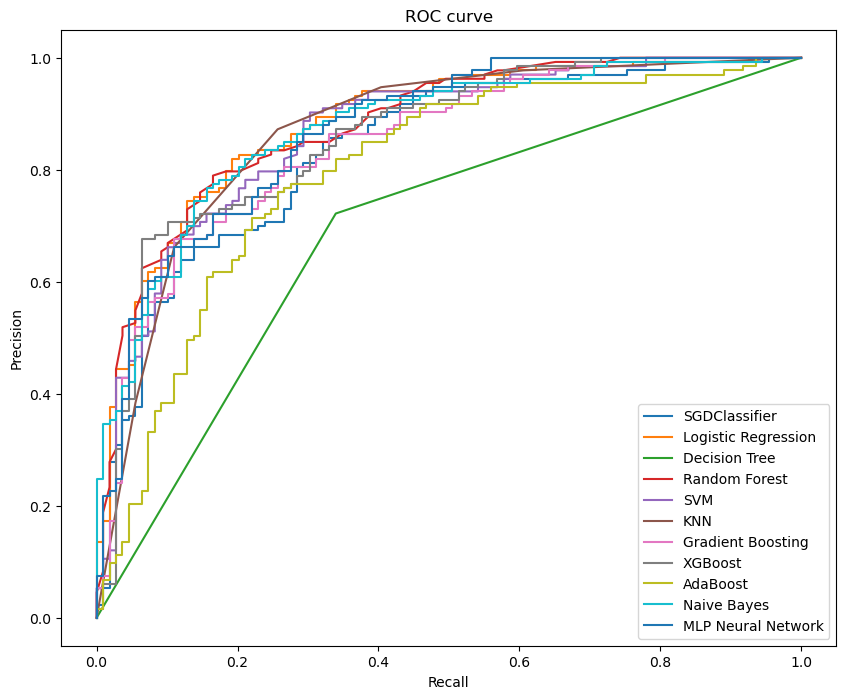

In [12]:
roc_graph(models)

# Resultado

In [13]:
df = pd.DataFrame(lscores)
df

,name,f1,r2,accuracy,precission,recall,error_mse,model_score,error_mae,roc_auc_score
0,SGDClassifier,0.8093,0.4741,0.7975,0.8387,0.7820,0.362143,"[0.7160493827160493, 0.7777777777777778, 0.8625]",0.131148,0.8385
1,Logistic Regression,0.8175,0.5399,0.7934,0.7943,0.8421,0.338754,"[0.8024691358024691, 0.7407407407407407, 0.8375]",0.114754,0.8832
2,Decision Tree,0.7082,0.3427,0.6901,0.7339,0.6842,0.404888,"[0.6419753086419753, 0.7160493827160493, 0.7125]",0.163934,0.6912
3,Random Forest,0.8060,0.4741,0.7851,0.8000,0.8120,0.362143,"[0.8148148148148148, 0.7407407407407407, 0.8]",0.131148,0.8807
4,SVM,0.8000,0.4741,0.7727,0.7746,0.8271,0.362143,"[0.7901234567901234, 0.7407407407407407, 0.7875]",0.131148,0.8666
5,KNN,0.8375,0.5399,0.8140,0.8056,0.8722,0.338754,"[0.8395061728395061, 0.7777777777777778, 0.825]",0.114754,0.8697
6,Gradient Boosting,0.7774,0.2769,0.7562,0.7803,0.7744,0.424650,"[0.7654320987654321, 0.7530864197530864, 0.775]",0.180328,0.8476
7,XGBoost,0.7692,-0.1832,0.7521,0.7874,0.7519,0.543214,"[0.7530864197530864, 0.7530864197530864, 0.75]",0.295082,0.8592
8,AdaBoost,0.7630,0.3427,0.7355,0.7518,0.7744,0.404888,"[0.7777777777777778, 0.691358024691358, 0.7375]",0.163934,0.7973
9,Naive Bayes,0.8209,0.5399,0.8017,0.8148,0.8271,0.338754,"[0.8271604938271605, 0.7901234567901234, 0.7875]",0.114754,0.8736


In [14]:
for name, model in models.items():
    predicciones = model.predict(x_test)

    errores=0
    for i, prediccion in enumerate(predicciones):
        if prediccion != list(y_test)[i]:
            errores+=1
    print(f"{name} FALLA EN: {errores} de {len(x_test)} con: {round(errores/len(x_test)*100, 2)}% de errores")

SGDClassifier FALLA EN: 8 de 61 con: 13.11% de errores
Logistic Regression FALLA EN: 7 de 61 con: 11.48% de errores
Decision Tree FALLA EN: 10 de 61 con: 16.39% de errores
Random Forest FALLA EN: 8 de 61 con: 13.11% de errores
SVM FALLA EN: 8 de 61 con: 13.11% de errores
KNN FALLA EN: 7 de 61 con: 11.48% de errores
Gradient Boosting FALLA EN: 11 de 61 con: 18.03% de errores
XGBoost FALLA EN: 18 de 61 con: 29.51% de errores
AdaBoost FALLA EN: 10 de 61 con: 16.39% de errores
Naive Bayes FALLA EN: 7 de 61 con: 11.48% de errores
MLP Neural Network FALLA EN: 8 de 61 con: 13.11% de errores


- Se puede observar que los siguientes modelos son los que mejor funcionan:
    - KNN
    - Logistic Regression
    - Naive Bayes

- Dependiendo de lo que busques, examina el json que salio como resultado para elegir lo que más te interese (accuracy, recall, etc)